In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Параметры
np.random.seed(42)
DATA_RANGE = 1000  # длина ряда

t = np.arange(DATA_RANGE)
# Модельный ряд
model_series = np.sin(0.1 * t) + 0.5 * np.cos(0.03 * t)
# Наблюдаемый сигнал (нелинейное преобразование + шум)
observed_series = np.sin(model_series**3) + np.random.normal(0, 0.1, DATA_RANGE)

model_series.shape, observed_series.shape


((1000,), (1000,))

In [3]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 model_series_input_size=MODEL_SERIES_INPUT_SIZE,
                 observed_series_input_size=OBSERVED_SERIES_INPUT_SIZE):
        self.model_series = model_series
        self.observed_series = observed_series
        self.model_series_input_size = model_series_input_size
        self.observed_series_input_size = observed_series_input_size
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = DATA_RANGE - self.model_series_input_size - self.observed_series_input_size
        X = np.zeros((l, self.model_series_input_size + self.observed_series_input_size))
        y = np.zeros(l)
        for i in range(l):
            X[i, :self.model_series_input_size] = self.model_series[i:i + self.model_series_input_size]
            X[i, self.model_series_input_size:] = self.observed_series[i:i + self.observed_series_input_size]
            y[i] = self.observed_series[i + self.model_series_input_size + self.observed_series_input_size]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
data = MixedDataGenerator(model_series, observed_series)

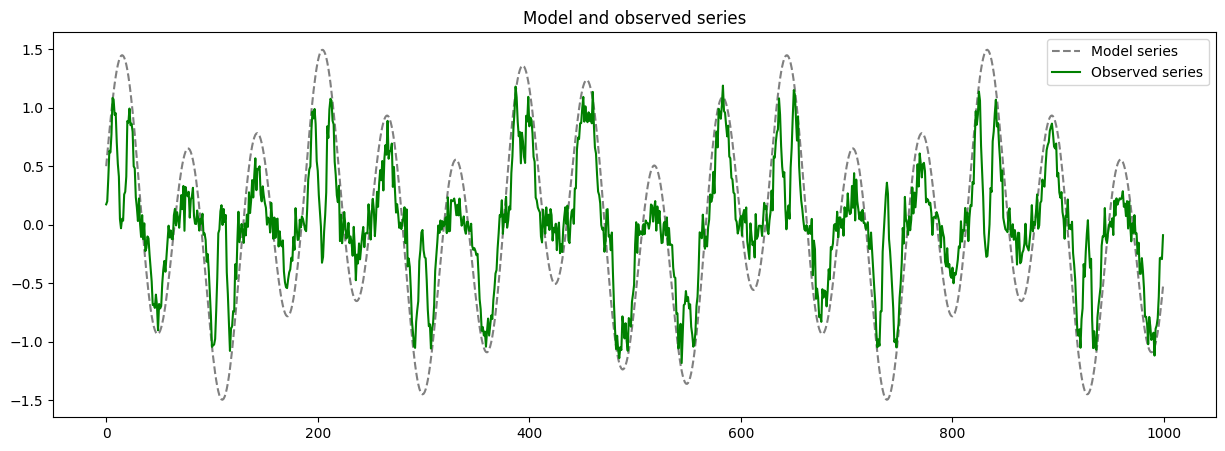

In [5]:
# plot
plt.figure(figsize=(15, 5))
plt.plot(model_series, label='Model series', linestyle='--', color='gray')
plt.plot(observed_series, label='Observed series', color='green')
plt.legend()
plt.title('Model and observed series')
plt.show()

In [6]:
# define the NARX model
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = self.fc2(out)
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE, hidden_size=64, output_size=1)

In [10]:
def train_model(model, epochs=100, learning_rate=0.001, data=data):
    train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=0.2, random_state=42)
    val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=0.5, random_state=42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    train_losses = []
    val_losses = []
    train_data_X = train_data_X.to(device)
    train_data_y = train_data_y.to(device)
    val_data_X = val_data_X.to(device)
    val_data_y = val_data_y.to(device)

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        outputs = model(train_data_X)
        loss = criterion(outputs.squeeze(), train_data_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(val_data_X)
        val_loss = criterion(val_outputs.squeeze(), val_data_y)
        val_losses.append(val_loss.item())

    return train_losses, val_losses
        
        

# Пример вызова функции
train_losses, val_losses = train_model(model, epochs=50, learning_rate=0.001, data=data)


100%|██████████| 50/50 [00:00<00:00, 248.14it/s]


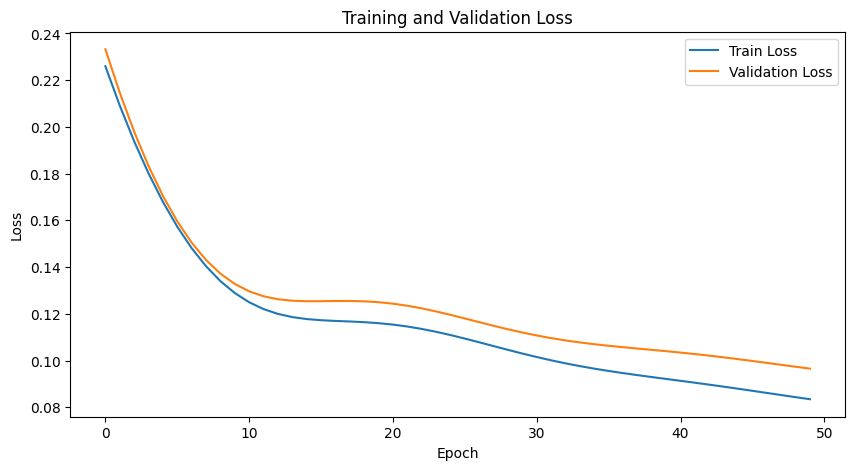

In [11]:
# График потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

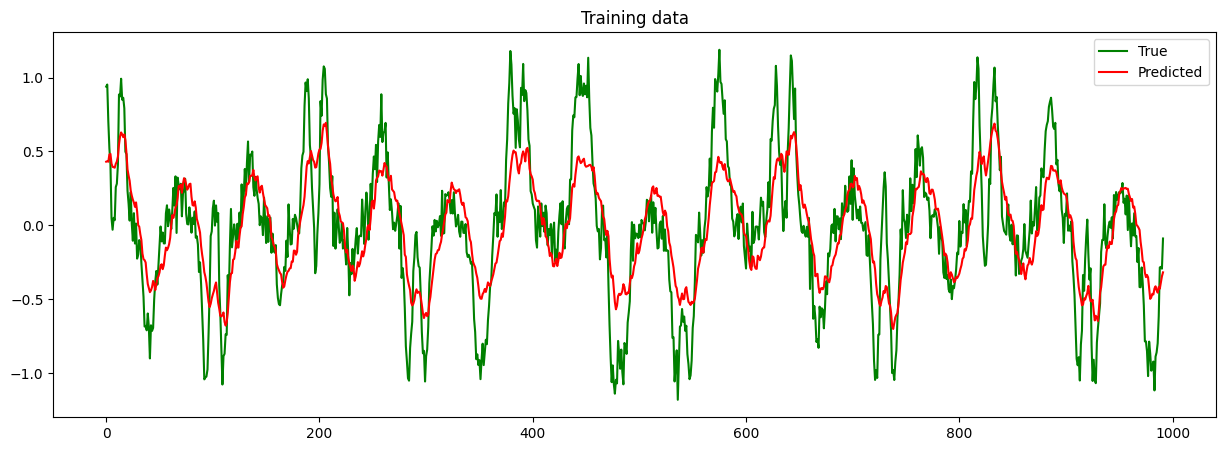

In [12]:
# График предсказаний на обучении
model.eval()
train_data_X = data.X.to(device)
train_data_y = data.y.to(device)
train_outputs = model(train_data_X)
plt.figure(figsize=(15, 5))
plt.plot(train_data_y.cpu(), label='True', color='green')
plt.plot(train_outputs.detach().cpu(), label='Predicted', color='red')
plt.title('Training data')
plt.legend()
plt.show()